In [39]:
import re
from pathlib import Path
from functools import lru_cache
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch

#location of the MERGED mortality panels (good for later when doing historical temp kde)
PANEL_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels")
PRODUCTS = ["MERRA2", "ERA5_025", "GMFD", "JRA_3Q"]  
CHUNK = 100_000

def make_crosswalk(product: str, panel_dir=PANEL_DIR, chunk=CHUNK) -> Path:
    panel_fn = panel_dir / f"global_mortality_panel_public_{product}.dta"

    #discover columns from the mortality panel 
    it = pd.read_stata(panel_fn, iterator=True, chunksize=chunk, convert_categoricals=False)
    first = next(it)
    cols = first.columns.tolist()

    #find the lr column
    lr_col = f"lr_tavg_{PRODUCT}_adm1_avg"

    #find the gdp column 
    gdp_col = "loggdppc_adm1_avg"

    needed = [c for c in ["adm0","adm1","adm1_id","adm2","adm2_id", gdp_col, lr_col] if c in cols]

    #Get only needed columns + iterate through the panel, drop duplicates 
    out = []
    it2 = pd.read_stata(panel_fn, iterator=True, chunksize=chunk,
                        convert_categoricals=False, columns=needed)
    for ch in it2:
        out.append(ch.drop_duplicates(["adm0","adm1_id","adm2_id"]))

    crosswalk = (pd.concat(out, ignore_index=True)
                   .drop_duplicates(["adm0","adm1_id","adm2_id"])
                   .sort_values(["adm0","adm1","adm2"])
                   .reset_index(drop=True))

    #save the product to a new csv
    out_csv = panel_fn.with_name(f"adm_crosswalk_{product}.csv")
    crosswalk.to_csv(out_csv, index=False)
    print(f"Wrote crosswalk: {out_csv}")
    return out_csv

#run for all products
written = []
for prod in PRODUCTS:
    try:
        p = make_crosswalk(prod)
        if p is not None:
            written.append(p)
    except Exception as e:
        print(f"{prod}: {e}")

print("\nDone. Files written:")
for p in written:
    print(" •", p)


MERRA2: Unable to allocate 29.8 MiB for an array with shape (39, 100000) and data type float64
ERA5_025: Unable to allocate 32.8 MiB for an array with shape (43, 100000) and data type float64
GMFD: Unable to allocate 32.8 MiB for an array with shape (43, 100000) and data type float64
JRA_3Q: Unable to allocate 32.8 MiB for an array with shape (43, 100000) and data type float64

Done. Files written:


In [57]:
import re, pandas as pd
from pathlib import Path

XWALK = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_ERA5_025.csv")

df = pd.read_csv(XWALK, dtype=str)
df["adm0_norm"] = df["adm0"].str.strip().str.lower()

# Mexico only
mx = df[df["adm0_norm"].eq("mexico")].copy()

# Look for a few hot/humid city/district names
pat = re.compile(r"veracruz|yucat|m[eé]rida|tabasco|villahermosa|tampico|campeche", re.I)
for col in ("adm1","adm2"):
    if col not in mx: mx[col] = ""  # just in case

mask = mx[["adm1","adm2"]].apply(lambda s: s.fillna("").str.contains(pat)).any(axis=1)
mx_hits = mx.loc[mask, [c for c in ["adm0","adm1","adm1_id","adm2","adm2_id"] if c in mx.columns]] \
           .drop_duplicates()

print(mx_hits.head(20).to_string(index=False))


  adm0     adm1 adm1_id                                                          adm2   adm2_id
Mexico Campeche       4                                                       Calkini 484004001
Mexico Campeche       4                                                      Campeche 484004002
Mexico Campeche       4 Carmen, Champoton, Hopelchen, Escarcega, Calakmul, Candelaria 484004003
Mexico Campeche       4                                                   Hecelchakan 484004004
Mexico Campeche       4                                                      Palizada 484004005
Mexico Campeche       4                                                        Tenabo 484004006
Mexico  Tabasco      27                                                      Balancan 484027001
Mexico  Tabasco      27                                                      Cardenas 484027002
Mexico  Tabasco      27                                                        Centla 484027003
Mexico  Tabasco      27                 

In [65]:
balancan = covars_for_adm(
    "ERA5_025",
    adm1_id="27",
    adm2_id="484027001",
    lat=20.9674, lon=-89.5926
) 

In [43]:
#generate the age-specific mortality curves in certain cities, generate uncertainty using Kevin's method.

#paths
CSVV_DIR   = Path("/user/ab5405/summeraliaclimate/code/regressions/output/age_spec_interacted_csvv")
CAR_PATHS_CSV = Path("/user/ab5405/summeraliaclimate/code/regressions/0_generate_obs_data/car_paths.csv")
CROSSWALK_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels")  # where adm_crosswalk_*.csv live

ALLOWED_PRODUCTS = {"MERRA2", "ERA5_025", "GMFD", "JRA_3Q"}  # guardrail for typos
SPEC        = "spec2"      # regression spec used for CSVVs
#axis
TMIN, TMAX  = -15.0, 45.0  # x-axis for plotting in °C
#window for calculating the min
SLICE_MIN, SLICE_MAX = 10.0, 25.0  # normalization window (min over this slice)
AGE_LABELS  = ["Young", "Middle", "Old"]


_float_re = r"[-+]?(?:\d+\.?\d*|\.\d+)(?:[Ee][-+]?\d+)?"

#Reads the entire csvv as text 
def _read_gamma_and_vcv(csvv_path: Path):
    txt = Path(csvv_path).read_text()
    
    #allows . to match newlines, and makes case insensitive 
    mg = re.search(r"\bgamma\s*(.*?)\bgammavcv\b", txt, flags=re.S|re.I)
    mv = re.search(r"\bgammavcv\b(.*)\Z",           txt, flags=re.S|re.I)

    #extract all the floats in the block, should be 36 blocks in total
    to_floats = lambda s: [float(x) for x in re.findall(_float_re, s)]
    need_g, need_v = 36, 36*36

    g = to_floats(mg.group(1))
    v = to_floats(mv.group(1))

    #reshapes to a 3x4x3 set, with 3 age groups, 4 poly terms for each, and 3 covariates for each
    gamma    = np.array(g[:need_g], dtype=float).reshape(3, 4, 3)
    gammavcv = np.array(v[:need_v], dtype=float).reshape(36, 36)
    return gamma, gammavcv

"""
    Draws gamma ~ N(mean, VCV), builds age-specific coefficients for (lr_tavg, loggdppc),
    evaluates quartic on T, and normalizes each draw by min over [slice_min, slice_max].
    Returns (y_mean, y_lo, y_hi) for the requested age.
    """

def _mc_bands_for_city_age(
    T,
    slice_min,
    slice_max,
    lr_tavg,
    loggdppc,
    gamma_mean: np.ndarray,   # (3,4,3)
    gamma_vcv: np.ndarray,    # (36,36)
    age_index: int,
    n_draws: int = 800,
    rng: np.random.Generator | None = None,
):
    rng = rng or np.random.default_rng(123)

    # Draw gamma ~ N(mean, VCV) then reshape to (n_draws, 3, 4, 3)
    g_mean_flat = gamma_mean.reshape(-1)
    draws = rng.multivariate_normal(g_mean_flat, gamma_vcv, size=n_draws).reshape(n_draws, 3, 4, 3)

    # draws shape: (n_draws, 3 ages, 4 poly terms, 3 covars)
    # covar indices: 0 -> intercept, 1 -> lr_tavg, 2 -> loggdppc
    b1 = (draws[:, age_index, 0, 0]
          + draws[:, age_index, 0, 1] * lr_tavg
          + draws[:, age_index, 0, 2] * loggdppc)
    
    b2 = (draws[:, age_index, 1, 0]
          + draws[:, age_index, 1, 1] * lr_tavg
          + draws[:, age_index, 1, 2] * loggdppc)
    
    b3 = (draws[:, age_index, 2, 0]
          + draws[:, age_index, 2, 1] * lr_tavg
          + draws[:, age_index, 2, 2] * loggdppc)
    
    b4 = (draws[:, age_index, 3, 0]
          + draws[:, age_index, 3, 1] * lr_tavg
          + draws[:, age_index, 3, 2] * loggdppc)

    # Stack into (n_draws, 4) for [T, T^2, T^3, T^4]
    eff = np.column_stack([b1, b2, b3, b4])

    # Evaluate quartic on T: y_raw = eff @ [T, T^2, T^3, T^4]
    Tpow  = np.vstack([T, T**2, T**3, T**4])                # (4, len(T))
    y_raw = eff @ Tpow                                      # (n_draws, len(T))

    # Normalize each draw by its own minimum over the baseline slice;
    # if the slice is empty, fall back to the global min — done without if-branches
    mask = (T >= slice_min) & (T <= slice_max)

    # take the minimum over the slice only; if a row is all-NaN in the slice,
    # base will be NaN (no filling/fallback)
    base = np.nanmin(y_raw[:, mask], axis=1)   # (n_draws,)
    
    y = y_raw - base[:, None]                 # (n_draws, n_T); rows with NaN base stay NaN
    
    # Aggregate bands
    #At each temperature T, take the average across draws, over the draws axis 
    y_mean = np.nanmean(y, axis=0)
    #take the 5th and 95th perceptiles across draws at each temperature (axis = 0), to be used for plotting later. 
    y_lo, y_hi = np.nanpercentile(y, [5, 95], axis=0)
    return y_mean, y_lo, y_hi


def coeffs_for_city(gamma_age_poly_covar, *, lr_tavg, loggdppc):
    """
    Make the 4 polynomial coefficients (b1..b4) for one age group.

    Parameters
    ----------
    gamma_age_poly_covar : array-like, shape (4, 3)
        Rows correspond to T, T^2, T^3, T^4 (in that order).
        Columns are:
          [0] = intercept term (1)
          [1] = coefficient on lr_tavg
          [2] = coefficient on loggdppc
    lr_tavg : float
        Long-run average temperature (adm1 avg) for the city.
    loggdppc : float
        Log GDP per capita (adm1 avg) for the city.

    Returns
    -------
    dict with keys "b1", "b2", "b3", "b4"
    """

    g = np.asarray(gamma_age_poly_covar, dtype=float)

    # Row 0 -> b1 (coefs for T^1)
    b1_const = g[0, 0]
    b1_lr    = g[0, 1]
    b1_gdp   = g[0, 2]
    b1 = b1_const + b1_lr * lr_tavg + b1_gdp * loggdppc

    # Row 1 -> b2 (coefs for T^2)
    b2_const = g[1, 0]
    b2_lr    = g[1, 1]
    b2_gdp   = g[1, 2]
    b2 = b2_const + b2_lr * lr_tavg + b2_gdp * loggdppc

    # Row 2 -> b3 (coefs for T^3)
    b3_const = g[2, 0]
    b3_lr    = g[2, 1]
    b3_gdp   = g[2, 2]
    b3 = b3_const + b3_lr * lr_tavg + b3_gdp * loggdppc

    # Row 3 -> b4 (coefs for T^4)
    b4_const = g[3, 0]
    b4_lr    = g[3, 1]
    b4_gdp   = g[3, 2]
    b4 = b4_const + b4_lr * lr_tavg + b4_gdp * loggdppc

    return {"b1": b1, "b2": b2, "b3": b3, "b4": b4}


def quartic_no_const(T: np.ndarray, b: dict) -> np.ndarray:
    """Evaluate b1*T + b2*T^2 + b3*T^3 + b4*T^4 on vector T (°C)."""
    return b["b1"]*T + b["b2"]*T**2 + b["b3"]*T**3 + b["b4"]*T**4


#get climate data + plot KDE 

def _open_any(path: str | Path) -> xr.Dataset:
    s = str(path)
    if s.endswith(".zarr"):
        return xr.open_zarr(s, consolidated=False)
    if s.lower().endswith((".grib", ".grb", ".grb2")):
        return xr.open_dataset(s, engine="cfgrib")
    return xr.open_dataset(s)

@lru_cache(None)
def _open_tas(product: str) -> xr.Dataset:
    """Open the product's raw tas dataset using car_paths.csv (assumes lat/lon/tas already correct)."""
    paths = pd.read_csv(CAR_PATHS_CSV, dtype=str)
    key = product.replace("_", "-").upper()
    row = paths.loc[paths["product"].str.upper() == key].iloc[0]

    ds = _open_any(row["tas_filepath"])  # opens zarr/netcdf/grib via your helper
    
    return ds

def kde_density_for_city_K(city: dict, Tgrid_C: np.ndarray, product: str, bw="scott") -> np.ndarray:
    """
    Compute a KDE of historical tas **in Kelvin** at the native grid cell nearest to
    (city['lat'], city['lon']). Evaluate the KDE at the Kelvin equivalents of the
    Celsius x-grid (Tgrid_C + 273.15), but *plot* against °C on the x-axis.
    """
    ds   = _open_tas(product)
    lat0 = float(city["lat"])
    lon0 = ((float(city["lon"]) + 180) % 360) - 180  # convert to [-180,180] domain

    ilat = int(np.argmin(np.abs(ds["lat"].values - lat0)))
    ilon = int(np.argmin(np.abs(ds["lon"].values - lon0)))

    temps_K = ds["tas"].isel(lat=ilat, lon=ilon).load().values.astype(float)  # typically daily
    temps_K = temps_K[np.isfinite(temps_K)]

    kde = gaussian_kde(temps_K, bw_method=bw)
    return kde(Tgrid_C + 273.15)  # evaluate KDE at Kelvin points


#get the covariates from the csvv

def covars_for_adm(product: str, adm1_id: str, adm2_id: str, *, lat=None, lon=None) -> dict:
    """
    Grab covariates for an ADM2 from the per-product crosswalk CSV.
    Assumes columns are uniformly named across products.
    """
    xwalk_fn = CROSSWALK_DIR / f"adm_crosswalk_{product}.csv"
    df = pd.read_csv(xwalk_fn, dtype=str)

    # exact column names we expect
    gdp_col = "loggdppc_adm1_avg"
    lr_col  = f"lr_tavg_{product}_adm1_avg"

    # coerce types we need
    df["adm1_id"] = df["adm1_id"].astype(str)
    df["adm2_id"] = df["adm2_id"].astype(str)
    df[gdp_col]   = pd.to_numeric(df[gdp_col], errors="coerce")
    df[lr_col]    = pd.to_numeric(df[lr_col],  errors="coerce")

    # exact match on IDs
    hit = df[(df["adm1_id"] == str(adm1_id)) & (df["adm2_id"] == str(adm2_id))]
    if hit.empty:
        raise ValueError(f"({adm1_id}, {adm2_id}) not found in {xwalk_fn.name}")

    r = hit.iloc[0]
    out = {
        "adm0":     r["adm0"],
        "adm1":     r["adm1"],
        "adm2":     r["adm2"],
        "adm1_id":  r["adm1_id"],
        "adm2_id":  r["adm2_id"],
        "loggdppc": float(r[gdp_col]),
        "lr_tavg":  float(r[lr_col]),
        "product":  product,
        "name":     r["adm2"] or r["adm1_id"],
    }
    out["lat"] = float(lat)
    out["lon"] = float(lon)
    return out


In [44]:
def _city_title(key: str, city: dict) -> str:
    forced = {"london": "London", "geneva": "Geneva", "calcutta": "Kolkata", "kolkata": "Kolkata"}
    return forced.get(key.lower(), city.get("name") or f"{city.get('adm2_id','')} ({city.get('adm1_id','')})")

def plot_age_curves_with_density(
    product: str,
    cov_dict: dict,
    *,
    spec: str = SPEC,
    csvv_dir: Path = CSVV_DIR,
    tmin: float = TMIN,
    tmax: float = TMAX,
    slice_min: float = SLICE_MIN,
    slice_max: float = SLICE_MAX,
    density_alpha: float = 0.25,
    baseline_band: bool = True,
    n_draws: int = 800,
    band_alpha: float = 0.18,
):
    # CSVV (mean + VCV)
    csvv_path = csvv_dir / f"agespec_interaction_response_{spec}_{product.replace('-','_')}.csvv"
    gamma_mean, gamma_vcv = _read_gamma_and_vcv(csvv_path)

    # Plot grid + RNG
    T   = np.linspace(tmin, tmax, 800)
    rng = np.random.default_rng(42)

    keys = list(cov_dict.keys())
    fig, axes = plt.subplots(1, len(keys), figsize=(5*len(keys), 5), sharey=False)
    if not isinstance(axes, (list, np.ndarray)):  # single panel -> make iterable
        axes = [axes]

    legend_lines = []

    for i, (ax, key) in enumerate(zip(axes, keys)):
        city = cov_dict[key]
        name = _city_title(key, city)

        if baseline_band:
            ax.axvspan(slice_min, slice_max, color="0.9", alpha=0.25, zorder=0)

        # Three age curves (posterior mean) + MC bands
        for a, age_label in enumerate(AGE_LABELS):
            y_mean, y_lo, y_hi = _mc_bands_for_city_age(
                T, slice_min, slice_max,
                lr_tavg=float(city["lr_tavg"]),
                loggdppc=float(city["loggdppc"]),
                gamma_mean=gamma_mean,
                gamma_vcv=gamma_vcv,
                age_index=a,
                n_draws=n_draws,
                rng=rng,
            )
            line, = ax.plot(T, y_mean, lw=2.2, label=age_label, zorder=3)
            ax.fill_between(T, y_lo, y_hi, color=line.get_color(), alpha=band_alpha, linewidth=0, zorder=2)
            if i == 0:
                legend_lines.append(line)

            # mark min within [slice_min, slice_max]
            win = (T >= slice_min) & (T <= slice_max)
            y_win = np.where(win, y_mean, np.nan)
            base_T = T[np.nanargmin(y_win)]
            ax.scatter([base_T], [0.0], s=18, color=line.get_color(), zorder=4)

        # KDE overlay (fit/eval in Kelvin; draw against °C)
        dens = kde_density_for_city_K(city, T, product, bw="scott")
        ax2 = ax.twinx()
        ax2.fill_between(T, 0, dens, color="0.7", alpha=density_alpha, zorder=0)
        ax2.set_yticks([])
        ax2.set_ylabel("Temp density (KDE, K)", color="0.5")

        ax.axhline(0, ls="--", color="k", lw=1, zorder=1)
        ax.set_xlim(tmin, tmax)
        ax.set_title(name)
        ax.set_xlabel("Temperature [°C]")
        ax.grid(False)

    axes[0].set_ylabel("Effect on mortality rate\nrelative to min over 10–25°C [per 100,000]")

    # Shared legend (ages + KDE proxy)
    fig.subplots_adjust(top=0.84)
    fig.legend(
        handles=legend_lines + [Patch(facecolor="0.7", alpha=density_alpha, label="Temp density (KDE)")],
        labels=AGE_LABELS + ["Temp density (KDE)"],
        loc="upper center",
        ncol=4,
        frameon=True,
        fontsize=9,
        borderaxespad=0.6
    )

    fig.suptitle(
        f"Spec 2 ({product}): age-specific curves + historical temp KDE (grid cell) + MC bands",
        y=0.93
    )
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()


In [45]:
#write cov dicts (found earlier from crosswalk)
geneva  = covars_for_adm("ERA5_025", adm1_id="CH0", adm2_id="CH01", lat=46.2044, lon=6.1432)
london  = covars_for_adm("ERA5_025", adm1_id="UKI", adm2_id="UKI4",  lat=51.5074, lon=-0.1278)
kolkata = covars_for_adm("ERA5_025", adm1_id="14",  adm2_id="9",     lat=22.5726, lon=88.3639)

cov_dict = {"LONDON": london, "GENEVA": geneva, "KOLKATA": kolkata}

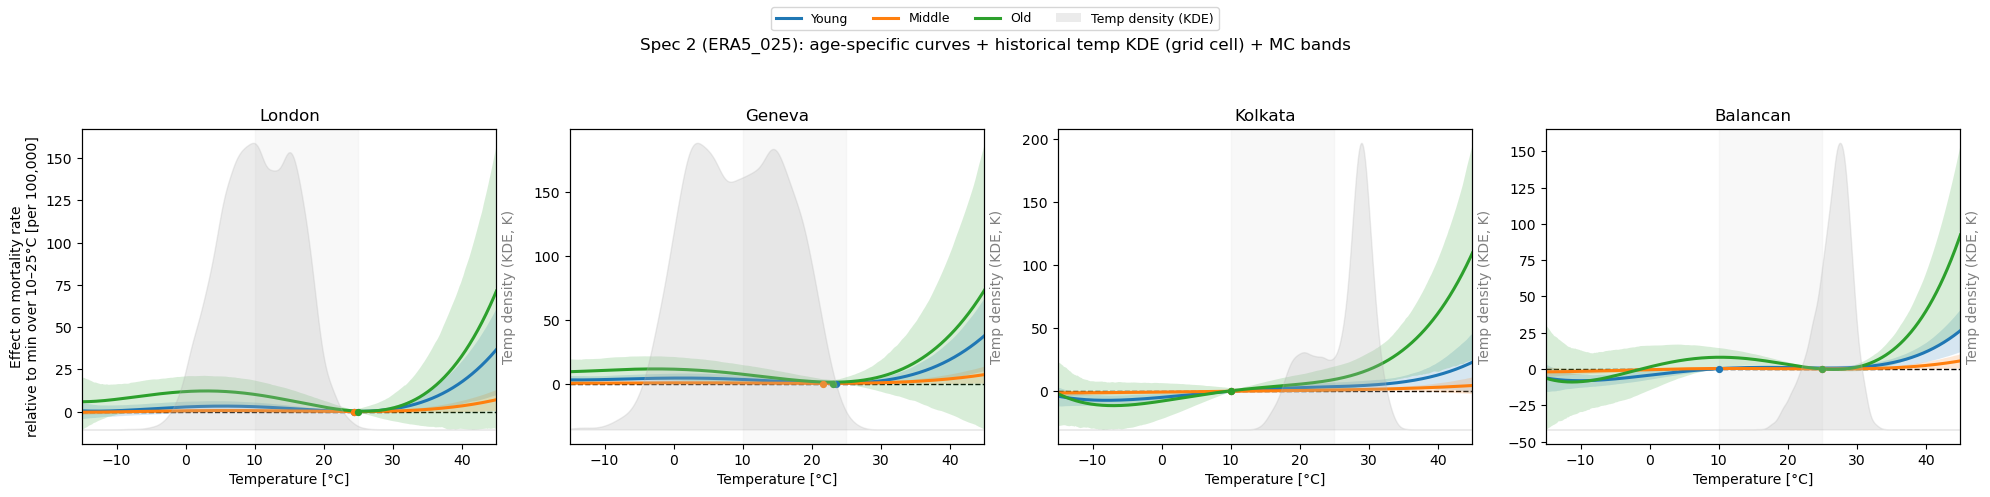

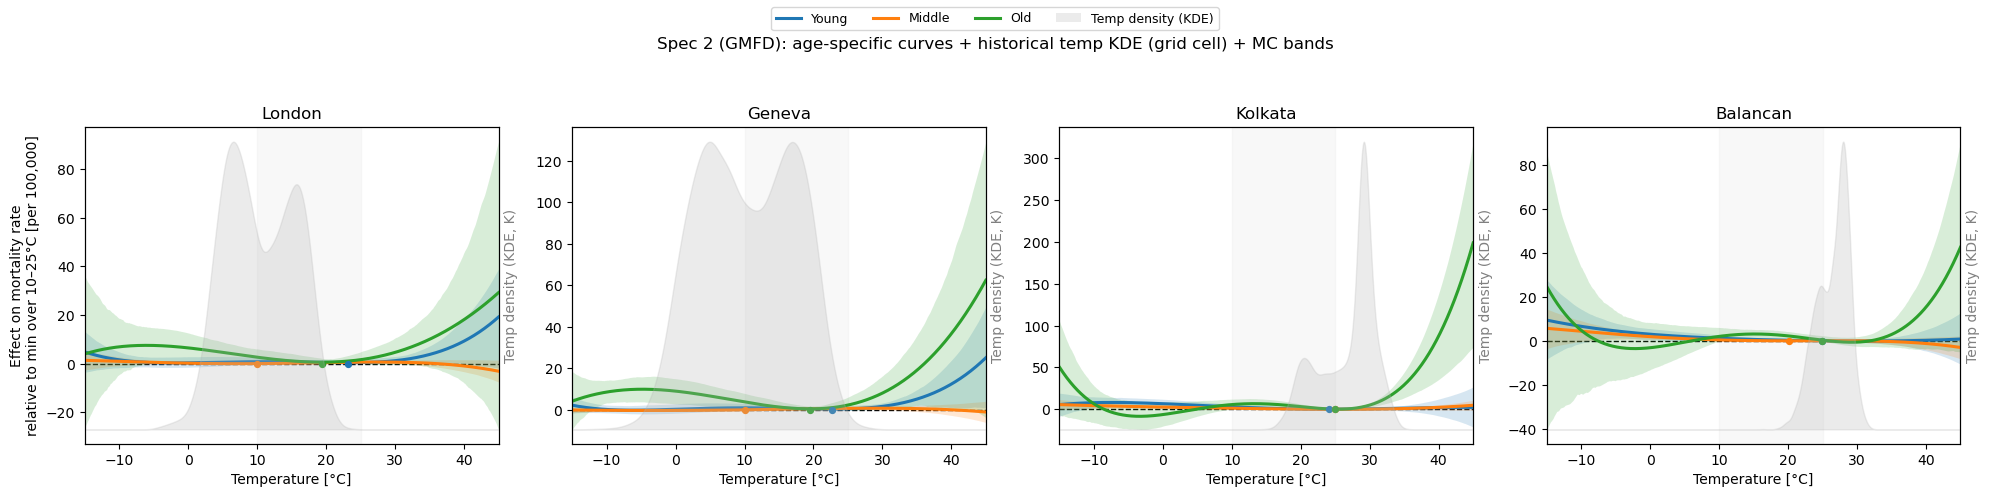

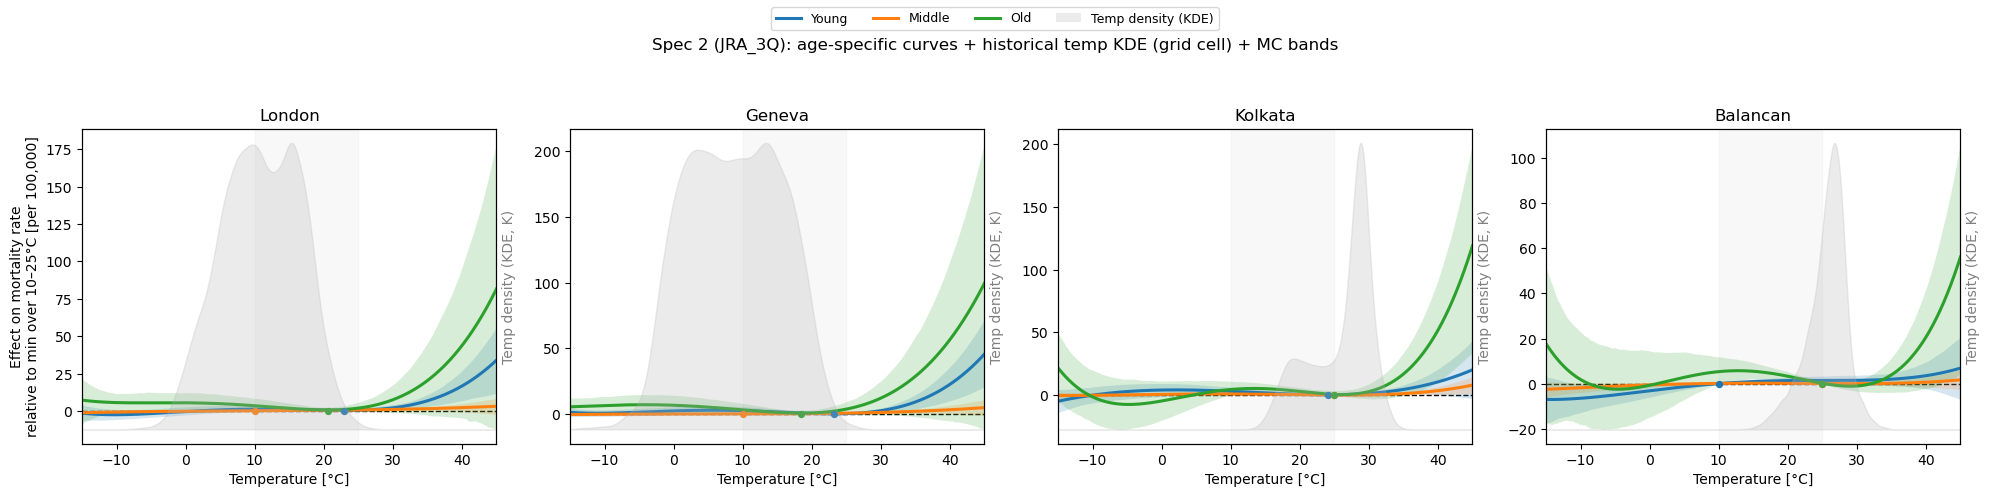

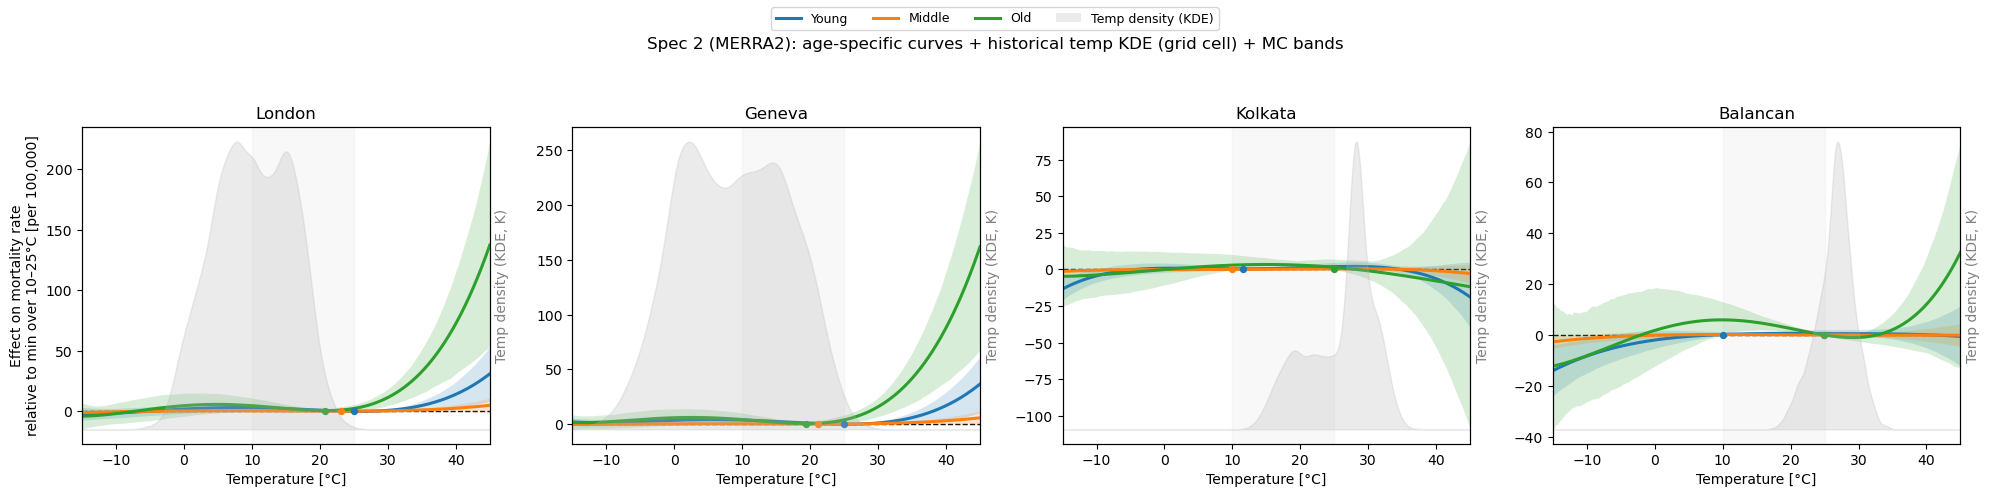

In [66]:
plot_age_curves_with_density("ERA5_025", cov_dict)
plot_age_curves_with_density("GMFD",     cov_dict)
plot_age_curves_with_density("JRA_3Q",   cov_dict)
plot_age_curves_with_density("MERRA2",   cov_dict)

In [63]:
def curve_metrics(cityA, cityB, *, age_idx=2,  # 0=Young,1=Middle,2=Old
                  T=np.linspace(TMIN, TMAX, 800),
                  slice_min=SLICE_MIN, slice_max=SLICE_MAX,
                  gamma_mean=None, gamma_vcv=None):
    
    # posterior mean curves using MC helper
    yA, _, _ = _mc_bands_for_city_age(
        T, slice_min, slice_max,
        lr_tavg=float(cityA["lr_tavg"]), loggdppc=float(cityA["loggdppc"]),
        gamma_mean=gamma_mean, gamma_vcv=gamma_vcv, age_index=age_idx,
        n_draws=800, rng=np.random.default_rng(0)
    )
    yB, _, _ = _mc_bands_for_city_age(
        T, slice_min, slice_max,
        lr_tavg=float(cityB["lr_tavg"]), loggdppc=float(cityB["loggdppc"]),
        gamma_mean=gamma_mean, gamma_vcv=gamma_vcv, age_index=age_idx,
        n_draws=800, rng=np.random.default_rng(1)
    )

    # min temp within normalization window
    m = (T >= slice_min) & (T <= slice_max)
    TminA = T[m][np.argmin(yA[m])] if m.any() else T[np.argmin(yA)]
    TminB = T[m][np.argmin(yB[m])] if m.any() else T[np.argmin(yB)]

    # heat-end slope via finite difference at 35°C
    def slope_at(x0, y):
        i = np.argmin(np.abs(T - x0))
        i = np.clip(i, 1, len(T)-2)
        return (y[i+1] - y[i-1]) / (T[i+1] - T[i-1])
    slopeA = slope_at(35.0, yA)
    slopeB = slope_at(35.0, yB)

    # L2 distance (area of squared difference)
    l2 = np.trapz((yA - yB)**2, T)

    return {
        "Tmin_norm_A": TminA, "Tmin_norm_B": TminB,
        "slope35_A": slopeA, "slope35_B": slopeB,
        "L2_diff": l2,
    }

# example (Old age group):
csvv_path = CSVV_DIR / f"agespec_interaction_response_{SPEC}_{'MERRA2'}.csvv"
gamma_mean, gamma_vcv = _read_gamma_and_vcv(csvv_path)

metrics = curve_metrics(cov_dict["KOLKATA"], cov_dict["BALANCAN"],
                        age_idx=2, gamma_mean=gamma_mean, gamma_vcv=gamma_vcv)
print(metrics)


{'Tmin_norm_A': np.float64(24.94993742177722), 'Tmin_norm_B': np.float64(24.94993742177722), 'slope35_A': np.float64(-0.8363175830742945), 'slope35_B': np.float64(1.1289145701581478), 'L2_diff': np.float64(6743.790570194792)}


/tmp/8368144.1.debian.q/ipykernel_18534/1651726846.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  l2 = np.trapz((yA - yB)**2, T)


In [64]:
def point_value(y, T, x):
    i = np.argmin(np.abs(T - x))
    return y[i]

# Values at hot end (posterior means)
yA, _, _ = _mc_bands_for_city_age(T=np.linspace(TMIN, TMAX, 800),
                                  slice_min=SLICE_MIN, slice_max=SLICE_MAX,
                                  lr_tavg=float(cov_dict["KOLKATA"]["lr_tavg"]),
                                  loggdppc=float(cov_dict["KOLKATA"]["loggdppc"]),
                                  gamma_mean=gamma_mean, gamma_vcv=gamma_vcv,
                                  age_index=2, n_draws=800, rng=np.random.default_rng(0))
yB, _, _ = _mc_bands_for_city_age(T=np.linspace(TMIN, TMAX, 800),
                                  slice_min=SLICE_MIN, slice_max=SLICE_MAX,
                                  lr_tavg=float(cov_dict["BALANCAN"]["lr_tavg"]),
                                  loggdppc=float(cov_dict["BALANCAN"]["loggdppc"]),
                                  gamma_mean=gamma_mean, gamma_vcv=gamma_vcv,
                                  age_index=2, n_draws=800, rng=np.random.default_rng(1))

Tgrid = np.linspace(TMIN, TMAX, 800)
print("Old-age value at 35°C:  Kolkata =", point_value(yA, Tgrid, 35),
      " Balancán =", point_value(yB, Tgrid, 35))
print("Old-age value at 40°C:  Kolkata =", point_value(yA, Tgrid, 40),
      " Balancán =", point_value(yB, Tgrid, 40))


Old-age value at 35°C:  Kolkata = -4.499306811826354  Balancán = 1.9895566322867537
Old-age value at 40°C:  Kolkata = -9.19244243187017  Balancán = 11.32278175410147
